In [ ]:
from header import *
from scipy import optimize
plt.rcParams.update({'font.size': 16})
plots_dir = Path('imgs/')
timelimit = 6

In [24]:
def plot_scaling(df, x, y, prefix, hline=False, algo1=None, algo2=None, show_mean=False, trend_line=False, xlog=False, ylog=False, title=None):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F3F3F3')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['alg', x], group_keys=False, observed=True)[y].mean()  # observed=True drops categorical algos that don't appear
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='alg', values='mean_{}'.format(y))
   
    if trend_line == "exp":        
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(s.index, np.log(s), 1)
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # ln(y[i]) ~= a*x[i] + b
        #  => y[i] ~= exp(a*x[i] + b)
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     a*x[1] + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(np.exp(a*i+b))
            #display(regression_line)
            ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
            weight = 'bold' if 'seeds' in algo else 'normal'
            label = '$\sim {{{:0.2f}}}^x$'.format(np.exp(a*(s.index[1]-s.index[0])))
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    elif trend_line == "poly":
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(np.log(s.index), np.log(s), 1)
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # log(y[i]) ~= a*log(x[i]) + b
        #  => y[i] ~= e^(a*log(x[i]) + b) = x[i]^a * e^b
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     x[i]*[ * + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append((i**a) * np.exp(b))
            #display(regression_line)
            
            weight = 'bold' if 'seeds' in algo else 'normal'
            label = ''
            if len(d[algo].dropna()) > 1:
                ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
                label = '$\sim x^{{{:0.2f}}}$'.format(a)
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    elif trend_line == "lin_poly":
        z = {}
        f = lambda x, a, b, c: a*x + b*x**c
        fe = lambda x, a, b, c: np.log(a*x + b*x**c)
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = optimize.curve_fit(fe, 
                                         s.index, 
                                         np.log(s), 
                                         p0=[1e-10, 1e-10, 2.5],
                                         bounds=([1e-20,1e-20,1], [1e-5, 1e-5, 3])
                                        )[0]
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            params = z[algo]
            print(params)
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(f(i, *params))
            #display(regression_line)
            
            weight = 'bold' if 'seeds' in algo else 'normal'
            label = ''
            if len(d[algo].dropna()) > 1:
                ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
                label = '$\sim {:0.2f} x + {:0.2f} * x^{{{:0.2f}}}$'.format(*params)
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    elif trend_line is not False:
        print(trend_line)
        assert(False)
    
    # ticks
    if x == 'error_rate':
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    
    if x == 'cost':
        ax.set_xticks(np.arange(0, max(df[x])+1, 1))
    
    #arr = [ 0 ] + [ 10**n for n in range(0,int(math.log10(max(df[y])))+1) ]
    #ax.set_yticks(arr)

    # Times
    #for index, row in d.iterrows():
        #print(row["astar-seeds"])
        #print(row["astar-seeds-intervals"])
    #    label = '{0:.3g}x'.format(row[algo1] / row[algo2])
    #    tmp_x = index if index != 'all' else len(d)-1
    #    tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
    #    ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [ algo2color(algo) for algo in d.columns ]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot(ax=ax, alpha=0.6, zorder=3, rot=0, color=colors, marker='o', ls='', legend=False)
    #d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    #if hline:
    #    ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 15}, framealpha=0.5)
    #else:
    #    ax.legend(loc="upper left", prop={'size': 15}, framealpha=0.5)

    if hline:
        if y == 'explored_states' or y == 'crumbs':
            miny = df.len.median()
            maxy = df.refsize.median()*df.len.median()
        elif y == 'explored_per_bp':
            miny = 1
            maxy = df.refsize.median()
        else:
            assert(False)
        
        ax.axhline(maxy, color='k', linestyle='--', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(0.0, maxy, 'max    ', ha='right', va='center', size=16)
        
        ax.axhline(y=miny, color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(0.0, miny, 'min    ', ha='right', va='center', size=16)

    if ylog:
        ax.set_yscale('log')
        
    if xlog:
        ax.set_xscale('log')
      
    if title:
        ax.set_title(title)
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labelsi
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

[2.42379831e-07 5.76626016e-11 1.80818832e+00]
[9.87916868e-08 4.54535305e-11 1.58689919e+00]
[1.89202083e-08 3.82451078e-11 1.68226195e+00]
[2.15608167e-07 6.65300488e-11 1.89119119e+00]
[1.66568428e-07 4.68694656e-11 1.65606813e+00]
[3.27258210e-08 4.56027976e-11 1.85391115e+00]
[2.14784579e-07 7.15037316e-11 1.96666825e+00]
[7.69485090e-07 5.70978559e-11 1.87805595e+00]
[6.78934852e-08 7.67413043e-11 2.05494805e+00]


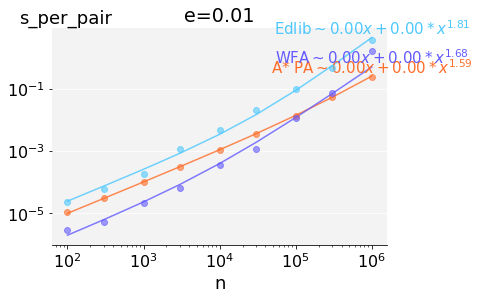

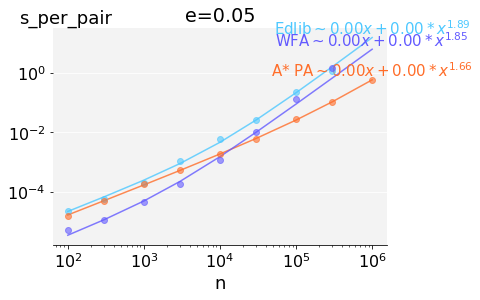

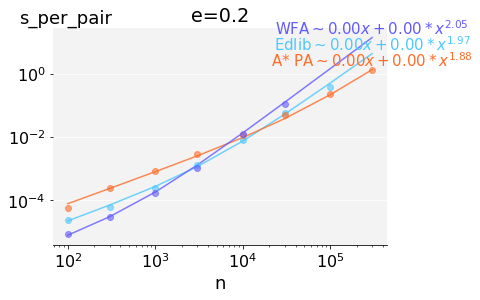

In [28]:
experiment_name = 'table'

df = read_benchmarks('../data/table/tools_N1000000.tsv')

df = df[ df.s < timelimit ]
df = df[df.alg != 'dijkstra']

#df['logs_per_pair'] = np.log(df['s_per_pair'])
#display(df)

for e in [0.01, 0.05, 0.2]:
    df_n = df[df.e == e]
    #display(df_n)
    plot_scaling(df_n, y='s_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True, trend_line='lin_poly', title='e={}'.format(e))
    #plot_scaling(df_e, y='s_per_pair', x='e', prefix=experiment_name, xlog=True, ylog=True)
    #plot_scaling(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)


df_e = df[df.n == 100000]
# error rate
#plot_scaling(df_n, y='logs_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True)
#plot_scaling(df_e, y='logs_per_pair', x='e', prefix=experiment_name, xlog=True, ylog=True)



[4.60265916e-08 7.21772140e-11 1.99797533e+00]
[2.42379831e-07 5.76626016e-11 1.80818832e+00]
[9.87916868e-08 4.54535305e-11 1.58689919e+00]
[1.89202083e-08 3.82451078e-11 1.68226195e+00]


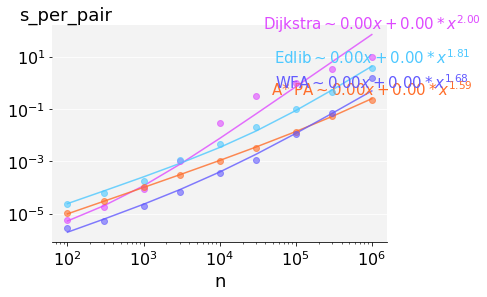

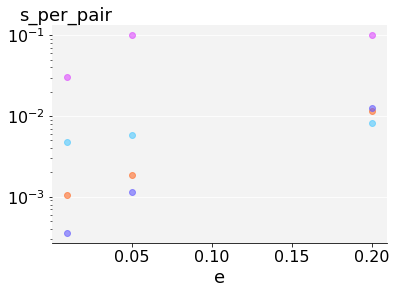

In [38]:
experiment_name = 'benchmark'

df = read_benchmarks('../data/table/tools_N1000000.tsv')

#df['logs_per_pair'] = np.log(df['s_per_pair'])
#display(df)

df_n = df[df.e == 0.01]
df_e = df[df.n == 10000]
#display(df_n)

# error rate
#plot_scaling(df_n, y='logs_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True)
#plot_scaling(df_e, y='logs_per_pair', x='e', prefix=experiment_name, xlog=True, ylog=True)

plot_scaling(df_n, y='s_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True, trend_line="lin_poly")
plot_scaling(df_e, y='s_per_pair', x='e', prefix=experiment_name, xlog=False, ylog=True, trend_line=False)
#plot_scaling(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)